In [1]:
%run 'testSkeleton_OQE_Functions.ipynb'

In [2]:
from scipy.stats import invwishart
from scipy import linalg
import pyuvdata as uvd
uvobj = uvd.UVData()
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
s = 120
nu_max, nu_min = 120, 100 # MHz units
inprange = nu_max - nu_min
nu_ = np.linspace(nu_min,nu_max,s)
nu, nup = np.meshgrid(nu_,nu_)
tau_ = np.fft.fftfreq(s, (nu_max-nu_min)/(s-1))
tau_f = flip(tau_)
print(tau_f[0:5])

[-2.975      -2.92541667 -2.87583333 -2.82625    -2.77666667]


In [4]:
at1,at2 = 0,1
simfile = '/home/kennedy/sims/viscatBCpoints.uvh5'
oldeorfile = '/home/kennedy/sims/600times/viscatBCeor.uvh5'
ats = (at1, at2)

uvobj.read(simfile)
bl = uvobj.get_data(ats)
C_f = np.cov(bl.T)

uvobj.read(oldeorfile)
eor600 = uvobj.get_data(ats)
C_eor600 = np.cov(eor600.T)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [5]:
rfi2 = np.load('rfi2.npy')
rfi5 = np.load('rfi5.npy')
rfi10 = np.load('rfi10.npy')

w0,w1,w2,w3 = np.ones((s,)),np.ones((s,)),np.ones((s,)),np.ones((s,))
w1[rfi2],w2[rfi5],w3[rfi10] = 0,0,0

wc1,wc2,wc3 = np.ones((s,)),np.ones((s,)),np.ones((s,))
wc1[40:42], wc2[40:46], wc3[40:52] = 0,0,0 

In [6]:
As, ws, k = 25e-2, 0.5, 5e-3
gc = As/1e1
C_signal = (gc*np.eye(s) + As * np.exp( -(nu-nup)**2 / ws**2  )) 
# C_signal = C_eor600
C_noise = k * np.eye(s) 

S = C_signal+C_f
N = C_noise
mv = np.zeros(s)
R = np.diag(BH(s))

In [7]:
Np = 1200 # number of data

truesigs = nsample(mv, C_signal, Np)

# signaltouse = eor
signaltouse = truesigs

Vft = bl[:Np] + signaltouse 

noiseS = (nsample(mv, C_noise, Np) + 1j*nsample(mv, C_noise, Np))/2**0.5
Vis_noise = Vft + noiseS # noisy data generated

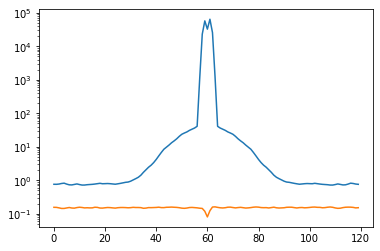

In [8]:
# signal and noise spectra for later comparison
pS = naivePS(Vft, meansub=1, taper=1)
tps = np.mean(pS, axis=0)
pSnoise = naivePS(noiseS, meansub=1, taper=1)
plt.plot(np.mean(pS, axis=0))
plt.plot(np.mean(pSnoise, axis=0))
plt.yscale('log')

In [78]:
def GCR_invw(dat, w, matlib):
    """
    
    GCR w/ fitted eigenmodes of C_foreground
    
    matlib[0]: Sh = sp.linalg.sqrtm( S ) ... etc.
    Si = np.linalg.inv( S )
    Ni = w.T*np.linalg.inv( N )*w
    Sih = sp.linalg.sqrtm( Si )
    Nih = sp.linalg.sqrtm( Ni )
    
    """
        
    Sh = matlib[0][0]
    Si = matlib[0][1]
    Ni = matlib[0][2]
    Sih = matlib[0][3]
    Nih = matlib[0][4]
    A = matlib[1][0]
    Ai = matlib[1][1]

    s = Sh.shape[0]

    d = dat.reshape((1,max(s,len(dat.T))))
    
    omi, omj = np.random.randn(s,1),np.random.randn(s,1)
    omk, oml = np.random.randn(s,1),np.random.randn(s,1)
    oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

    b = Ni @ (w*d).T + Sih@oma + Nih @ omb
        
    xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)
    
    return xboth

In [17]:
def GCR_invwarray(V, w, matlib, ncpu=2):
    
    ndat = V.shape[0]
    nfreq = V.shape[1]
    
    VS = np.zeros(V.shape, dtype=complex)
    
    Vidxs = np.arange(ndat)
    
    st=time.time()
    
    with Pool(ncpu) as pool:
        VS = pool.map(lambda idx: GCR_invw(V[idx], w, matlib), Vidxs)

    print('%.1fs'%(time.time()-st), end=' ')
    return np.array(VS).reshape(V.shape)

In [84]:
def Gibbs_invw_step(vis, S, N, flags):
    
    Nvis, Nfreq = vis.shape
    
    matlib = [0,0]
    matlib[0] = np.zeros((5,Nfreq,Nfreq),dtype=complex)
    matlib[1] = np.zeros((2,Nfreq,Nfreq),dtype=complex)
    
    matlib[0][0] = sp.linalg.sqrtm( S )
    matlib[0][1] = np.linalg.inv( S )  # Si
    matlib[0][2] = flags.T*np.linalg.inv( N )*flags  # Ni
    matlib[0][3] = sp.linalg.sqrtm( matlib[0][2] ) # Sih
    matlib[0][4] = sp.linalg.sqrtm( matlib[0][4] )  # Nih
    
   
    A = matlib[0][1] + matlib[0][2]       # Si + Ni  

    
    matlib[1][0] = A
    matlib[1][1] = np.linalg.inv(A)
    
    crs = GCR_invwarray(vis, flags, matlib, ncpu=2)
    
    matdfs = (Nfreq**2 + Nfreq)/2
    
    Snew = CIW_sample2((2*(Nvis+matdfs)-2*Nfreq-1)*(np.cov(crs.T)), df=2*(Nvis+matdfs))
#     Snew = invwishart.rvs(Np+matdfs, (Np+matdfs-Nfreq-1)*(np.cov(crs.T)).real, size=1)
    
    return crs, Snew

In [19]:
def Block(C):
    
    N = S.shape[0]
    Block = np.zeros((2*N,2*N))

    Block[0:N,0:N]    = C.real/2
    Block[N:2*N,N:2*N]= C.real/2
    Block[0:N,N:2*N]  = C.imag/-2
    Block[N:2*N,0:N]  = C.imag/2
    
    return Block
    
def Unblock(C):
    
    N = C.shape[0]
    Cunblock = np.zeros((N//2,N//2),dtype=complex)
        
    Cunblock.real = C[:N//2,:N//2] + C[N//2:N,N//2:N]
    Cunblock.imag = C[N//2:N,0:N//2] - C[0:N//2,N//2:N]
    
    return Cunblock
    
def CIW_sample2(S, df):
    
    #complex inverse wishart sample passing through block form (of real and imag parts)
    
    return Unblock(  invwishart.rvs( df, Block(S), size=1) ) 

In [108]:
# GIBBS RUN


name = 'run3' # change iter.s afterwards
savfol = 'Gibbs-runs/'

Niter = 800

cr_store = np.zeros((Niter,Np,120), dtype=complex)
S_store = np.zeros((Niter,120,120), dtype=complex)
# S_store = np.zeros((Niter,120,120))

# first step - use correct cov
# run1 - 800 iters no flag SNR 5/1
# run2 - as above but complex this time, no flag and SNR 50/1
# run3 - 800 iters no flag SNR 5/1

flagging = w0

cr_store[0] , S_store[0] = Gibbs_invw_step(Vis_noise*flagging, S, N, flagging)

np.save(savfol+'truesigs-'+name+'.npy',signaltouse)
np.save(savfol+'noise-'+name+'.npy',noiseS)

# following steps - take iterated cov

for i in range(Niter-1):
    print('IT#%d'%(i+1),end=', ')
#     cr_store[i+1] , S_store[i+1] = Gibbs_invwishart_step(Vis_noise*wc3, S_store[i]+S_imag, N, wc3) # re-adding the correct imag part
    
    cr_store[i+1] , S_store[i+1] = Gibbs_invw_step(Vis_noise*flagging, S_store[i], N, flagging) 
    if not i%500:
    
        np.save(savfol+'cr-'+name+'.npy',cr_store)
        np.save(savfol+'S-'+name+'.npy',S_store)
        
np.save(savfol+'cr-'+name+'.npy',cr_store)
np.save(savfol+'S-'+name+'.npy',S_store)

0.6s IT#1, 0.6s IT#2, 0.7s IT#3, 0.6s IT#4, 0.6s IT#5, 0.7s IT#6, 0.7s IT#7, 0.7s IT#8, 0.7s IT#9, 0.7s IT#10, 0.7s IT#11, 0.7s IT#12, 0.6s IT#13, 0.7s IT#14, 0.7s IT#15, 0.7s IT#16, 0.7s IT#17, 0.7s IT#18, 0.6s IT#19, 0.7s IT#20, 0.7s IT#21, 0.7s IT#22, 0.7s IT#23, 0.7s IT#24, 0.6s IT#25, 0.6s IT#26, 0.7s IT#27, 0.6s IT#28, 0.7s IT#29, 0.7s IT#30, 0.6s IT#31, 0.6s IT#32, 0.7s IT#33, 0.7s IT#34, 0.7s IT#35, 0.7s IT#36, 0.7s IT#37, 0.7s IT#38, 0.6s IT#39, 0.7s IT#40, 0.6s IT#41, 0.7s IT#42, 0.6s IT#43, 0.6s IT#44, 0.7s IT#45, 0.7s IT#46, 0.7s IT#47, 0.7s IT#48, 0.7s IT#49, 0.6s IT#50, 0.7s IT#51, 0.6s IT#52, 0.6s IT#53, 0.7s IT#54, 0.6s IT#55, 0.6s IT#56, 0.6s IT#57, 0.6s IT#58, 0.7s IT#59, 0.7s IT#60, 0.7s IT#61, 0.7s IT#62, 0.8s IT#63, 0.7s IT#64, 0.7s IT#65, 0.7s IT#66, 0.6s IT#67, 0.7s IT#68, 0.7s IT#69, 0.7s IT#70, 0.7s IT#71, 0.7s IT#72, 0.6s IT#73, 0.7s IT#74, 0.7s IT#75, 0.7s IT#76, 0.6s IT#77, 0.7s IT#78, 0.7s IT#79, 0.7s IT#80, 0.7s IT#81, 0.6s IT#82, 0.6s IT#83, 0.6s IT#84, 0

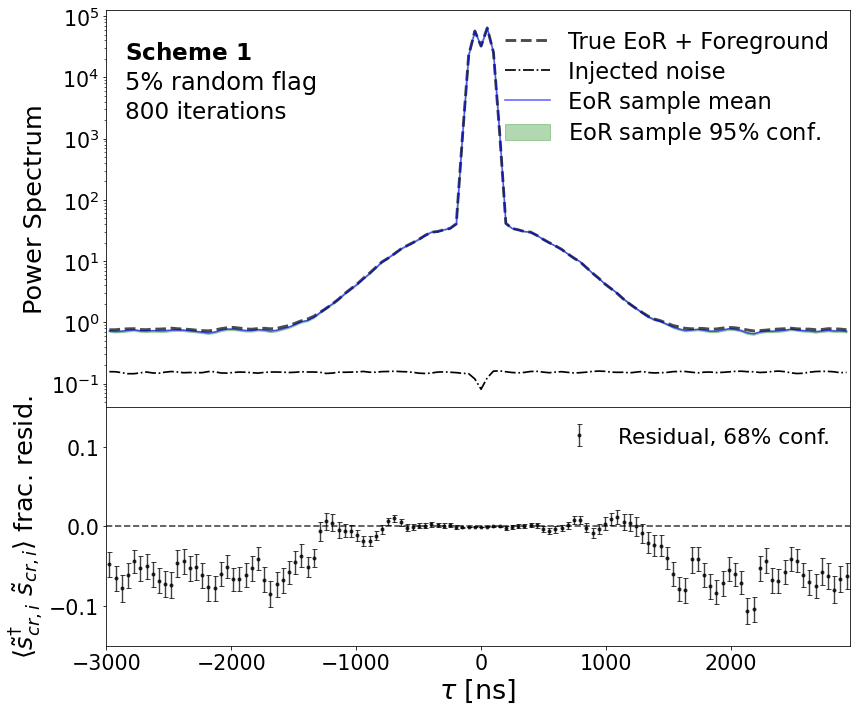

In [23]:
Niter=800
flagtag = '5% random flag'
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[1,0.6]})

fsb = 8.1
lwb = 0.5

tps = np.mean(pS, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))


for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real


# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)


ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')

# ax2.plot(tau_f*1e3, (cr_0/tps)-1, 'k-', alpha=0.75, lw=1.8+lwb, label='Residual mean')
# ax2.plot(tau_f*1e3, (cr_p2/tps)-1, 'k--', alpha=0.5, lw=1+lwb, label=r'95$\%$ conf.')
# ax2.plot(tau_f*1e3, (cr_m2/tps)-1, 'k--', alpha=0.5, lw=1+lwb)

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

# ax3.plot(tau_f*1e3, (cr_0_/pst_)-1, 'k-', alpha=0.75, lw=1.8+lwb, label='Residual mean')
# ax3.plot(tau_f*1e3, (cr_p2_/pst_)-1, 'k--', alpha=0.5, lw=1+lwb, label=r'95$\%$ conf.')
# ax3.plot(tau_f*1e3, (cr_m2_/pst_)-1, 'k--', alpha=0.5, lw=1+lwb)



# ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=14.5+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15)

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(labelsize=12.5+fsb)

ax1.text(-2850,2e4, r'$\bf{Scheme~1}$', fontsize=15+fsb)
ax1.text(-2850,6.45e3, flagtag, fontsize=16+fsb)
ax1.text(-2850,22e2, '%d iterations'%Niter, fontsize=15+fsb)
ax1.set_ylabel(r'Power Spectrum', fontsize=17.5+fsb)
ax2.set_ylabel(r'$\langle \tilde s_{cr,i}^\dag ~\tilde s_{cr,i} \rangle$ frac. resid.', fontsize=17.5+fsb)
ax2.set_ylim(-0.15,0.15)
ax1.tick_params(labelbottom=False)
ax2.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)
plt.tight_layout()

plt.savefig('figs/Gibbs/0-5-ci.pdf')

In [96]:
# samp = invwishart.rvs(1200+7260, (1200+7260-120-1)*S.real, size=1)

# plt.imshow(samp)
# plt.colorbar()

In [13]:
name = 'run3'
savfol = 'Gibbs-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
tps = np.mean(naivePS(signaltouse+bl, meansub=1, taper=1),axis=0)
pS = naivePS(signaltouse+bl, meansub=1, taper=1)


In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,11), sharex=True, gridspec_kw={'hspace':0})
ax1.set_title('inv-wishart draws, %d LSTs,'%Np, fontsize=16)
colors = plt.cm.cool(np.linspace(0,1,Niter-2))
for i in range(Niter-2):
    ax1.plot(tau_f*1e3, np.mean(naivePS(cr_store[i], meansub=1, taper=1), axis=0), 'y-', alpha=0.4)
    ax2.plot(tau_f*1e3, (np.mean(naivePS(cr_store[i], meansub=1, taper=1)-np.mean(pS, axis=0), axis=0))/np.mean(pS, axis=0),\
             c=colors[i], alpha=0.4)
ax1.plot(tau_f*1e3, np.mean(naivePS(Vis_noise, meansub=1, taper=1), axis=0),'b--', alpha=0.5, label='mean data PS')
ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='true PS')
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'b-', label='noise only')
ax1.legend()
ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--')
for ax in [ax1,ax2]:
    ax.set_xlim(-3e3, 3e3)
ax2.fill_between(tau_f*1e3,1-np.percentile(pS, 84.2,axis=0)/np.mean(pS, axis=0), 1-np.percentile(pS, 15.8,axis=0)/np.mean(pS, axis=0),color='b', alpha=0.1)
ax2.fill_between(tau_f*1e3,(1-np.percentile(pS, 84.2,axis=0)/np.mean(pS, axis=0))/Np**0.5, (1-np.percentile(pS, 15.8,axis=0)/np.mean(pS, axis=0))/Np**0.5,color='g', alpha=0.3)

ax1.text(-2700,1e6, 'no flag', fontsize=19)
ax2.set_ylabel('fractional residual', fontsize=14)
ax2.set_xlabel(r'$\tau$ [$\mu$s]', fontsize=14)
ax2.set_ylim(-1,1)
ax1.tick_params(labelbottom=False)


In [ ]:
Niter=100
ps = np.zeros((100,120),dtype=complex)

for i in range(100):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real

cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)

tps = np.mean(pS, axis=0).real

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10), sharex=True, gridspec_kw={'hspace':0})
# ax1.set_title('FG joint fitting, %d LSTs, %d iters'%(Np,Niter), fontsize=16)

# colors = plt.cm.cool(np.linspace(0,1,Niter))
# for i in range(Niter):
#     ax2.plot(tau_f*1e3, (np.mean(naivePS(crs_store[i], meansub=1, taper=1)-np.mean(pS, axis=0), axis=0))/np.mean(pS, axis=0),\
#              'k-', alpha=0.4)
    
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.6, label='sample mean PS')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label='2sigma samples')
# ax1.plot(tau_f*1e3, cr_p1, 'b-', alpha=0.6)
# ax1.plot(tau_f*1e3, cr_p2, 'b-', alpha=0.6)
# ax1.plot(tau_f*1e3, cr_m1, 'b-', alpha=0.6)
# ax1.plot(tau_f*1e3, cr_m2, 'b-', alpha=0.6)

ax2.plot(tau_f*1e3, (cr_0/tps)-1, 'k-', alpha=0.7, lw=1.8, label='residual mean')
ax2.plot(tau_f*1e3, (cr_p1/tps)-1, 'k--', alpha=0.6, lw=1.4, label=r'$1\sigma$')
ax2.plot(tau_f*1e3, (cr_p2/tps)-1, 'k-.', alpha=0.5, lw=1, label=r'2$\sigma$')
ax2.plot(tau_f*1e3, (cr_m1/tps)-1, 'k--', alpha=0.6, lw=1.4)
ax2.plot(tau_f*1e3, (cr_m2/tps)-1, 'k-.', alpha=0.5, lw=1)
ax2.legend(frameon=False, fontsize=16)


# ax1.plot(tau_f*1e3, np.mean(naivePS(Vis_noise, meansub=1, taper=1), axis=0),'b--', alpha=0.5, label='mean data PS')
ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='true PS', alpha=0.7, lw=2.4)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='noise only', lw=1.2)
ax1.legend(frameon=False, fontsize=16)
ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2, alpha=0.7)
for ax in [ax1,ax2]:
    ax.set_xlim(-3e3, 3e3)
    
# ax2.fill_between(tau_f*1e3,1-np.percentile(pS, 84.2,axis=0)/np.mean(pS, axis=0), 1-np.percentile(pS, 15.8,axis=0)/np.mean(pS, axis=0),color='b', alpha=0.1)
# ax2.fill_between(tau_f*1e3,(1-np.percentile(pS, 84.2,axis=0)/np.mean(pS, axis=0))/Np**0.5, (1-np.percentile(pS, 15.8,axis=0)/np.mean(pS, axis=0))/Np**0.5,color='g', alpha=0.3)



ax1.text(-2700,1e6, '5% continuous flag', fontsize=16)
ax1.text(-2700,2e5, 'Complex inverse-Wishart', fontsize=16)
ax1.text(-2700,4e4, '%d iters.'%Niter, fontsize=16)

ax2.set_ylabel('fractional residual', fontsize=14)
ax2.set_xlabel(r'$\tau$ [$\mu$s]', fontsize=14)
ax2.set_ylim(-0.2,0.2)
ax1.tick_params(labelbottom=False)

In [ ]:
# comparison with the 1000 run, errorbar looks about the same but this has
#

In [ ]:
# plt.plot(1-np.percentile(pS, 15.8,axis=0)/np.mean(pS,axis=0))
# plt.plot(1-np.percentile(pS, 84.2,axis=0)/np.mean(pS,axis=0))

In [ ]:
VCt = np.zeros(Vis_noise.shape, dtype=complex)

st=time.time()

Vidxs = np.arange(Vis_noise.shape[0])

with Pool(2) as pool:
    VCt = pool.map(lambda idx: GCR(Vis_noise[idx], w0, S, N, nrzn=1, inpaint=None, poolmap=True), Vidxs)
print('%.3f'%(time.time()-st))

In [ ]:
for i in range(Np):
    VCt[i] = pool.map(lambda idx: GCR(Vis_noise.T[:,idx], w0, S, N, nrzn=1, inpaint=None, poolmap=True), Vidxs)
print('%.3f'%(time.time()-st))

In [ ]:
plt.plot(.T.real)
plt.plot(Vft[100].T.real)
plt.plot(VCt[100].T.real)

In [ ]:
np.array(VCt).reshape(Vft.shape).shape